# 0. Применение метода KNN для решения задачи классификации

Набор данных получен в результате переписи населения 1994 года и содержит информацию о некотором количестве людей, проживающих в США. Задача состоит в том, чтобы предсказать, зарабатывает человек более $50к в год или нет. Список признаков:

*   <b>age</b>: возраст человека.
*   <b>workclass</b>: статус занятости.
*   <b>fnlwgt</b>: количество людей, которое, по мнению переписи, представляет запись.
*   <b>education</b>: высший уровень образования, достигнутый человеком.
*   <b>education-num</b>: высший уровень образования, достигнутый человеком в числовой форме.
*   <b>marital-status</b>: семейное положение человека.
*   <b>occupation</b>: общий род занятий человека.
*   <b>relationship</b>: представляет то, чем этот человек является по отношению к другим (перекликается с признаком <b>marital-status</b>).
*   <b>race</b>: раса.
*   <b>sex</b>: пол.
*   <b>capital-gain</b>: прирост капитала.
*   <b>capital-loss</b>: убыток капитала.
*   <b>hours-per-week</b>: число рабочих часов в неделю.
*   <b>native-country</b>: страна происхождения.
*   <b>the label</b>: отклик -- зарабатывает больше $50к или меньше.



## Немного про метрики качества модели

Для начала рассмотрим так называемую матрицу ошибок (confusion matrix)
-- способ разделить объекты на $4$ группы в зависимости от комбинации
истинного класса и ответа классификатора:

-   TP (True Positives) -- верно классифицированные объекты, исходно     относящиеся к классу "$+1$";

-   TN (True Negatives) -- верно классифицированные объекты, исходно     относящиеся к классу "$-1$";

-   FN (False Negatives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$+1$" (ошибка I рода);

-   FP (False Positives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$-1$" (ошибка II рода).

Обычно, конечно, оперируют не абсолютными показателями, а относительными
-- долями (rates), находящимися в диапазоне от $0$ до $1$:

-   доля правильных ответов классификатора (иногда -- точность): $$\mathsf{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}.$$ Эта величина показывает отношение количества верно классифицированных объектов к общему количеству классифицируемых объектов и, грубо говоря, оценивает вероятность случайному объекту быть правильно классифицированным.

-   доля истинно положительных примеров -- True Positives Rate (TPR) или     Sensitivity (чувствительность) или Recall: $$\mathsf{T P R}=\frac{T P}{T P+F N}.$$ Эта величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$+1$", к общему количеству объектов класса "$+1$". Иными словами -- это оценка вероятности, что объект, относящийся к классу "$+1$" будет классифицирован корректно.

-   доля ложно положительных примеров обозначается как -- False Positives Rate (FPR): $$\mathsf{F P R}=\frac{F P}{FP + TN}.$$ Величина показывает отношение количества неверно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован неверно.

-   Специфичность (Specificity) или True Negatives Rate (TNR): $$\mathsf{TNR} = 1 - \mathsf{F P R} =\frac{T N}{T N+F P}.$$ Величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован верно.

-   Precision (точность): $$\mathsf{Precision} =\frac{TP}{TP + FP}.$$ Величина показывает, какая доля объектов, отнесенных классификатором к классу "$+1$", действительно относится к этому классу.

Естественно возникает вопрос, нет ли какого-то обобщающего критерия,
который может характеризовать качество построенной модели. Один из них --
так называемая $F$-мера ($F_1$-мера, $F$ score, $F_1$ score)
определяется следующим соотношением:
$$F = F_1 = 2 \cdot \frac{\mathsf{Precision} \cdot \mathsf{Recall}}{\mathsf{Precision} + \mathsf{Recall}}.$$

**Замечание**. *$F$-мера является средним гармоническим величин
$\mathsf{Precision}$ и $\mathsf{Recall}$ и заключена в диапазоне
$[0, 1]$. Среднее гармоническое обладает важным свойством: оно близко к
нулю, если хотя бы один из аргументов близок к нулю. Поэтому оно является
куда более предпочтительным, чем, скажем, среднее арифметическое: если
алгоритм относит все объекты к положительному классу, то
$\mathsf{Recall}= 1$, а $\mathsf{Precision}$, скорее всего, будет
небольшим. Но тогда среднее арифметическое будет больше, чем $0.5$, что,
конечно, никуда не годится.*

## Импорт библиотек и чтение набора данных

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer 
import seaborn as sns
from matplotlib import pyplot as plt

Считайте набор данных в датафрейм. Исходя из описания признаков можно сразу избавиться от признаков <code>education</code> и <code>marital-status</code>. Удалите соответствующие колонки из набора данных.

In [8]:
df = pd.read_csv('C:/Users/Соня/OneDrive/Рабочий стол/jupyter/ml_online_course/knn/adult_data_train.csv')
drop_cloumn = df[['education', 'marital-status']]
df = df.drop(['education', 'marital-status'], axis=1)

Определите количество числовых и нечисловых признаков.

In [7]:
df.info()
# 6 нечисловых признаков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26048 entries, 0 to 26047
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             26048 non-null  int64 
 1   workclass       26048 non-null  object
 2   fnlwgt          26048 non-null  int64 
 3   education-num   26048 non-null  int64 
 4   occupation      26048 non-null  object
 5   relationship    26048 non-null  object
 6   race            26048 non-null  object
 7   sex             26048 non-null  object
 8   capital-gain    26048 non-null  int64 
 9   capital-loss    26048 non-null  int64 
 10  hours-per-week  26048 non-null  int64 
 11  native-country  26048 non-null  object
 12  label           26048 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 2.6+ MB


Постройте гистограмму распределения объектов по классам. Вычислите долю объектов класса $0$.

0.7591753685503686

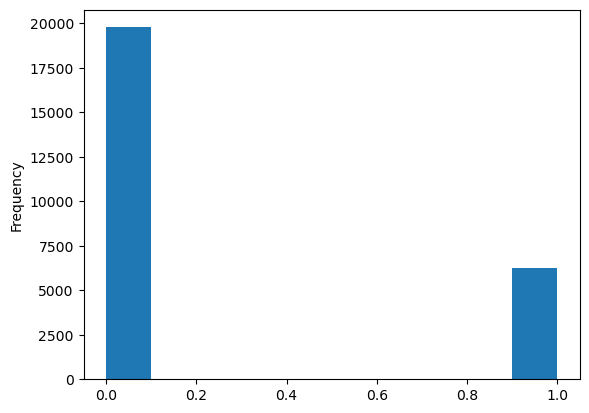

In [16]:
#plt.hist(df['label'], color = 'blue', edgecolor = 'black')
df['label'].plot.hist()
len(df[df['label'] == 0]) / len(df)

# 1. Построение базовой модели

В качестве первого приближения имеет смысл построить модель классификации, опираясь исключительно на числовые признаки.

Отберите из набора данных только числовые признаки. При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки <b>с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>label</code>.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных.

Обучите модель <code>KNeighborsClassifier()</code> с параметрами по умолчанию на тренировочных данных. 

Как видно из предыдущего пункта, в наборе данных наблюдается явный дисбаланс представителей классов. Это следует учесть при оценке модели. Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.

В качестве альтернативы можно использовать так называемый <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html"><code>classification_report()</code></a>, где приведены сразу несколько метрик (не стоит забывать про параметр <code>digits</code>).

In [52]:
numerical_df = df[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss','hours-per-week','label']]
Y = df[['label']]
X_train, X_test, y_train, y_test = train_test_split(numerical_df, Y, test_size=0.2, random_state=15, stratify=numerical_df['label'])

In [53]:
round(np.mean(X_train['fnlwgt']), 3)

190689.824

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

model = KNeighborsClassifier()
model.fit(X_train, y_train)
f1_score(y_test, model.predict(X_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.3732928679817906

Стоит помнить, что KNN является метрическим классификатором, поэтому значения признаков перед обучением модели следует нормировать.

Обучите преобразование <code>MinMaxScaler()</code> на тренировочном наборе данных и примените его для тренировочных и тестовых данных.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных после нормировки.

Заново обучите и оцените модель на преобразованных данных. Вычислите <code>f1_score()</code> модели.

In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
col = X_train.columns

res = scaler.fit_transform(X_train)
X_train = pd.DataFrame(res, columns = col)

res = scaler.transform(X_test)
X_test = pd.DataFrame(res, columns = col)

In [56]:
round(np.mean(X_train['fnlwgt']), 3)

0.121

In [58]:
model = KNeighborsClassifier()
model.fit(X_train[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss','hours-per-week']], y_train)
f1_score(y_test, model.predict(X_test[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss','hours-per-week']]))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.5151092515109252

Видно, что после линейной нормировки качество выросло. 

<b>Важно: </b>На дальнейших этапах подразумевается использование линейной нормировки непосредственно перед обучением без дополнительных напоминаний.

# 2. Работа с нечисловыми признаками

## Визуализация

Для дальнейшего улучшения качества модели имеет смысл задействовать нечисловые признаки исходного датасета (без колонок <code>education</code> и <code>marital-status</code>). 

Постройте гистограммы, иллюстрирующие частоту того или иного значения по каждому нечисловому признаку, например, при помощи <code>sns.barplot()</code>.

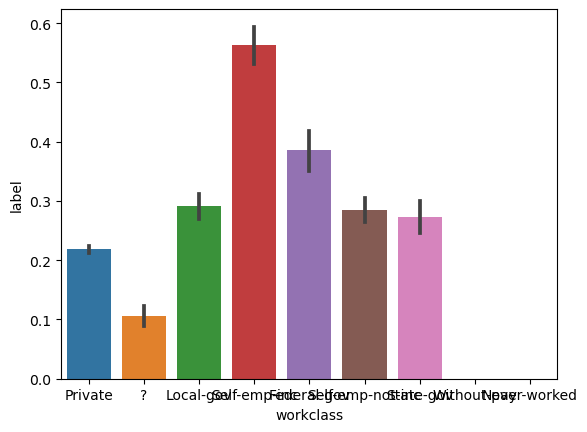

In [78]:
#sns.barplot(data=df, x='workclass')
#sns.histplot(data=tips_df, x="tip_percentage", binwidth=0.05, hue="time")
sns.barplot(x='workclass', y='label', data=df);

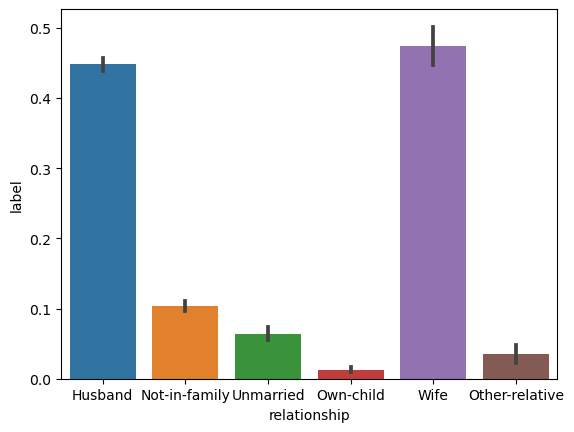

In [71]:
sns.barplot(x='relationship', y='label', data=df);

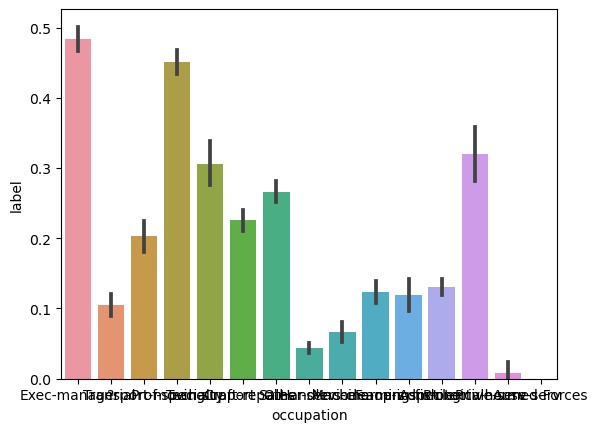

In [70]:
sns.barplot(x='occupation', y='label', data=df);

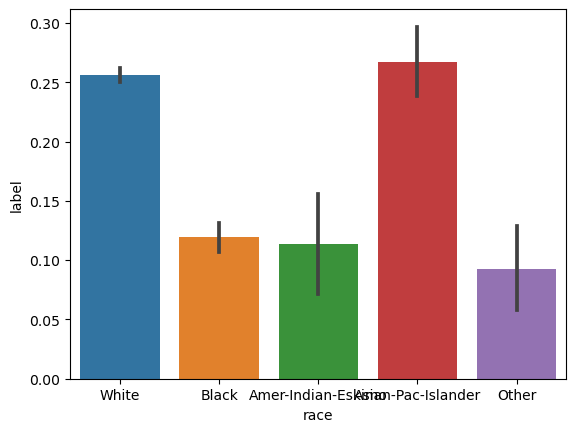

In [72]:
sns.barplot(x='race', y='label', data=df);

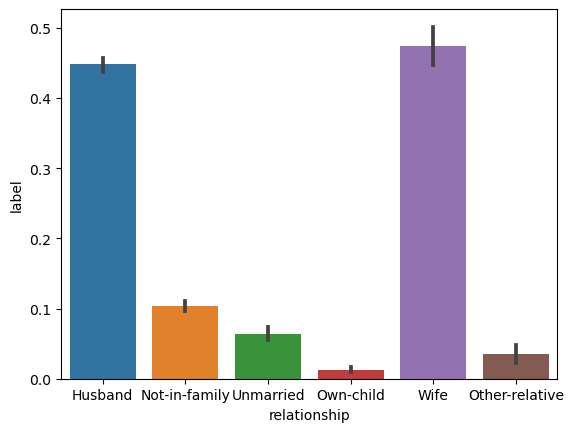

In [73]:
sns.barplot(x='relationship', y='label', data=df);

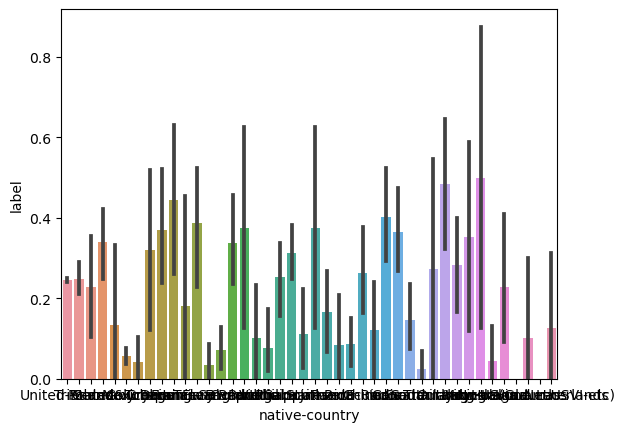

In [74]:
sns.barplot(x='native-country', y='label', data=df);

In [99]:
df.groupby('workclass')
df.groupby('relationship').plot.hist()
df.groupby('occupation').plot.hist()
df.groupby('race').plot.hist()
df.groupby('relationship').plot.hist()
df.groupby('native-country').plot.hist()
#sns.barplot(x='relationship', y='label', data=df);
.

SyntaxError: invalid syntax (3042545355.py, line 8)

In [98]:
#len(df.groupby('workclass')) 9
#len(df.groupby('relationship')) 6
#len(df.groupby('occupation')) 15
#len(df.groupby('race')) 5
#len(df.groupby('relationship')) 6
#len(df.groupby('native-country')) 42

## Удаление пропущенных значений

Определите число строк исходного набора данных (без колонок <code>education</code> и <code>marital-status</code>), в которых присутствует хотя бы одно пропущенное значение.

In [116]:
df_None = df.replace('?', np.nan)
df_None

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,NaN,122244,9,NaN,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,9,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,10,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,9,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,13,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


In [117]:
df_None = df_None.dropna()

In [118]:
df_None

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
3,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
5,51,Private,237630,9,Tech-support,Husband,White,Male,7298,0,50,United-States,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,9,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,10,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,9,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,13,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


Видно, что в датасете содержится менее 10% строк, содержащих пропуски. Выкидывать такое количество строк — не очень хорошее дело, но почему бы не попробовать обойтись без них. 

Удалите строки, содеражащие пропуски. Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>.

Введите число полученных признаков.

In [123]:
df_None = pd.get_dummies(df_None, drop_first=True)
df_None

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,32,37210,13,0,0,45,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,43,101950,14,0,0,45,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,40,24763,10,6849,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,24,113936,13,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,51,237630,9,7298,0,50,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,179171,9,0,0,38,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26044,39,421633,10,0,0,30,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
26045,55,82098,9,0,0,55,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
26046,26,50053,13,0,0,55,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


Обучите модель классификации аналогично тому, как это было проделано для базовой модели. Вычислите <code>f1_score()</code> модели.



In [130]:
Y = df_None[['label']]
df_without = df_None.drop(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_None, Y, test_size=0.2, random_state=15, stratify=df_None['label'])

scaler = MinMaxScaler()
col = X_train.columns

res = scaler.fit_transform(X_train)
X_train = pd.DataFrame(res, columns = col)
X_train = X_train.drop(['label'], axis=1)

res = scaler.transform(X_test)
X_test = pd.DataFrame(res, columns = col)
X_test = X_test.drop(['label'], axis=1)

model = KNeighborsClassifier()
model.fit(X_train, y_train)
f1_score(y_test, model.predict(X_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.6074007220216607

In [128]:
X_train

,label,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19302,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19303,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19304,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19305,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Точность модели увеличилась по сравнению с моделью, которая использовала только числовые признаки.

## Заполнение пропущенных значений

Возможно точность еще повысится, если задействовать строки с пропущенными значениями. Используя исходный датасет (без колонок <code>education</code> и <code>marital-status</code>), заполните пропуски самым часто встречающимся значением в рамках столбца.

In [138]:
df_N = df.replace('?', np.nan)
df_mode = df_N.fillna(df_N.mode().iloc[0])
df_mode = pd.get_dummies(df_mode, drop_first=True)
df_mode

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,32,37210,13,0,0,45,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,43,101950,14,0,0,45,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,20,122244,9,0,0,28,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,40,24763,10,6849,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,24,113936,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,179171,9,0,0,38,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26044,39,421633,10,0,0,30,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
26045,55,82098,9,0,0,55,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
26046,26,50053,13,0,0,55,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


Далее по уже знакомому сценарию: <code>one-hot</code>, <code>split</code>, <code>scaling</code>, обучение и оценка.

Вычислите <code>f1_score()</code> модели.

In [139]:
Y = df_mode[['label']]

X_train, X_test, y_train, y_test = train_test_split(df_mode, Y, test_size=0.2, random_state=15, stratify=df_mode['label'])

scaler = MinMaxScaler()
col = X_train.columns

res = scaler.fit_transform(X_train)
X_train = pd.DataFrame(res, columns = col)
X_train = X_train.drop(['label'], axis=1)

res = scaler.transform(X_test)
X_test = pd.DataFrame(res, columns = col)
X_test = X_test.drop(['label'], axis=1)

model = KNeighborsClassifier()
model.fit(X_train, y_train)
f1_score(y_test, model.predict(X_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.6122625215889466

## Проклятие размерности

В последнем пункте был получен набор данных, содержащий 76 признаков (кстати, попробуйте объяснить, почему в случае удаления строк число признаков в итоге оказалось равным 75), что является достаточным для того, чтобы столкнуться с так называемым проклятием размерности.

Для того, чтобы классификатор давал более качественные результаты, имеет смысл более внимательно и вдумчиво поработать с признаками с учетом проклятия размерности. Например, вернуть в рассмотрение признаки <code>education-num</code> и <code>marital-status</code>. А также более глубоко вникнуть в саму природу признаков.

## Задание 3

In [ ]:
df_N = df.replace('?', np.nan)
df_mode = df_N.fillna(df_N.mode().iloc[0])
df_mode = pd.get_dummies(df_mode, drop_first=True)
df_mode

In [183]:
test = pd.read_csv("C:/Users/Соня/OneDrive/Рабочий стол/jupyter/bd/adult_data_reserved.csv")
test = test.drop(['education', 'marital-status'], axis=1)
test = test.replace('?', np.nan)
test = test.fillna(test.mode().iloc[0])
test = pd.get_dummies(test, drop_first=True)

In [178]:
for i in range(len(df_mode.columns)):
    if df_mode.columns[i] not in test_w.columns:
        print(df_mode.columns[i])

label
native-country_Holand-Netherlands


In [184]:
X_train, X_test, y_train = df_mode.drop(['label', 'native-country_Holand-Netherlands'], axis=1), test, df_mode['label']

In [197]:
scaler = MinMaxScaler()
col = X_train.columns

res = scaler.fit_transform(X_train)
X_train = pd.DataFrame(res, columns = col)
#X_train = X_train.drop(['label', 'native-country_Holand-Netherlands'], axis=1)

res = scaler.transform(X_test)
X_test = pd.DataFrame(res, columns = col)
#X_test = X_test.drop(['label'], axis=1)

model = KNeighborsClassifier()
model.fit(X_train, y_train)
predicted_y = model.predict(X_test)
predicted_y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,

In [198]:
predicted_y.T

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,